<img style="float: left; height: 175px; width: 175px" src="../landlab_logo_picture.jpg"> <h3 style="margin: 117px 0 0 185px; font-weight: 300;">a toolkit for modeling earth surface processes</h3>

## How to read a DEM as a Landlab grid

The starting point is to obtain a Digital Elevation Model (DEM) in ESRI's Ascii Grid format, or convert it to this format. The format consists of a 6-line header followed by elevation values. Here we'll work with a small example DEM file 'west_bijou_gully.asc'. The header for this file is as follows:

``ncols        43
nrows        89
xllcorner    559705.000000000000
yllcorner    4380220.000000000000
cellsize     3
NODATA_value 0``

Here, our objective is to translate the contents of this file into a Landlab RasterModelGrid. We'll do this using the ``read_esri_ascii`` function. Here's how it works:


In [1]:
from landlab.io import read_esri_ascii

In the line above, we go to Landlab's input/output library ("io") and import the function. Next, let's look at the basic documentation:

In [2]:
help(read_esri_ascii)

Help on function read_esri_ascii in module landlab.io.esri_ascii:

read_esri_ascii(asc_file, grid=None, reshape=False, name=None, halo=0)
    Read :py:class:`~landlab.RasterModelGrid` from an ESRI ASCII file.
    
    Read data from *asc_file*, an ESRI_ ASCII file, into a
    :py:class:`~landlab.RasterModelGrid`.  *asc_file* is either the name of
    the data file or is a file-like object.
    
    The grid and data read from the file are returned as a tuple
    (*grid*, *data*) where *grid* is an instance of
    :py:class:`~landlab.RasterModelGrid` and *data* is a numpy
    array of doubles with that has been reshaped to have the number of rows
    and columns given in the header.
    
    .. _ESRI: http://resources.esri.com/help/9.3/arcgisengine/java/GP_ToolRef/spatial_analyst_tools/esri_ascii_raster_format.htm
    
    Parameters
    ----------
    asc_file : str of file-like
        Data file to read.
    reshape : boolean, optional
        Reshape the returned array, otherwise ret

Ok, this tells us we need to supply the name of the file. If we want the data as a 2D array, we also specify ``reshape = True``. If we want to attach the elevation data to the grid as a field, we also give a name for the field as the ``name`` parameter. For example:

In [3]:
(mg, z) = read_esri_ascii('west_bijou_gully.asc', name='topographic__elevation')

Let's plot the grid:

In [4]:
from landlab.plot.imshow import imshow_grid

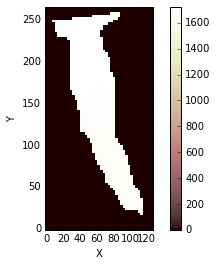

In [5]:
%matplotlib inline
imshow_grid(mg, 'topographic__elevation')

This plot illustrates the shape of the watershed, but we can't see the topography because the nodata values have a value of zero which is skewing the colormap.  We can change the range of the colormap but first we need to figure out what the range of data values are. 

(Uncomment the commented line if you want to see all the options available in imshow_grid)

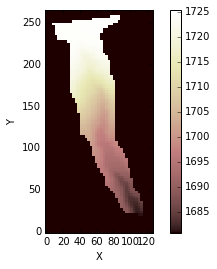

In [6]:
import numpy as np
min_z = np.min(z[np.where(z>0)])
max_z = np.max(z[np.where(z>0)])
#help(imshow_grid)
imshow_grid(mg, 'topographic__elevation', limits=(min_z,max_z))

We can also query a bit of information:

In [7]:
mg.number_of_node_rows

89

In [8]:
mg.number_of_node_columns

43

## The rest of this tutorial illustrates setting boundary conditions on DEMs and using the halo option for reading in DEMs without nodata values around the edges.

Because this is a watershed, we probably want to set watershed boundary conditions.  For more on setting watershed boundary conditions on rasters, see this tutorial: https://nbviewer.jupyter.org/github/landlab/tutorials/blob/master/boundary_conds/set_watershed_BCs_raster.ipynb

We also replot the watershed, this time coloring by the node status, which illustrates the boundary condition at each node.

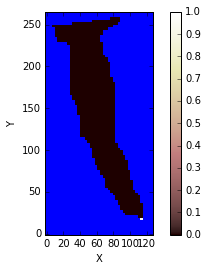

In [9]:
mg.set_watershed_boundary_condition(z, 0)
imshow_grid(mg, mg.status_at_node, color_for_closed='blue')

All of the closed boundary nodes are shown in blue.  Without the color_for_closed option they would plot as the minimum value, or black.  A value of 0 node status means that the node is a core node, or operational, and a value of 1 means that the node is a fixed value boundary.

### Now we illustrate reading in a DEM that is not a watershed, and use of the halo option.

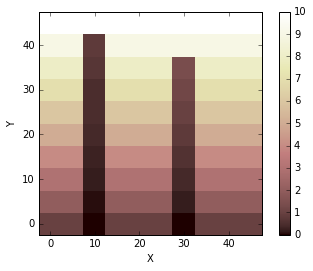

In [10]:
(mg1, z1) = read_esri_ascii('synthetic_landscape.asc', name='topographic__elevation')
imshow_grid(mg1, z1)

This landscape has data values at all of it's points.  (Note that the nodata_value is -9, but all of the values plotted here are >= 0.)

If we set an open boundary on the bottom or south side, and the rest of the boundaries as closed, as illustrated below, some of our data values will become closed boundaries, and operations will not be carried out at these nodes.  This is illustrated in the map of boundary status values, which has the three blue sides.

Note that the default is that the perimeter will have fixed value node status, or a value of 1.

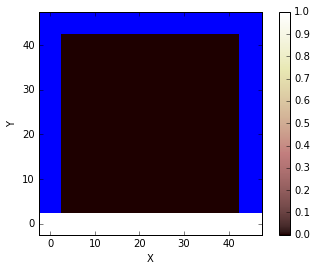

In [11]:
mg1.set_closed_boundaries_at_grid_edges(True, True, True, False)
imshow_grid(mg1, mg1.status_at_node, color_for_closed='blue')

The implication of this map is that the right, top and left edges are closed now, and therefore these node values will not be operated on. Similarly the bottom row is fixed value, so it also won't be operated on.

Supposed we want to include some or all of these values in model operations.  We need to set them as core nodes, but we can't have core nodes on the perimeter of a grid.  In this case we need to add a halo around the grid.  The halo option adds a perimater of nodes around the data that are read in from the esri_ascii file.  This is helpful when there are data values at the edges of a grid.  By default, the halo perimeter nodes will have the nodata value.

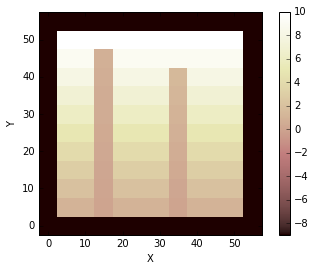

In [12]:
(mg2, z2) = read_esri_ascii('synthetic_landscape.asc', name='topographic__elevation', halo=1)
imshow_grid(mg2, z2)

It is helpful to know the no data value and other values in the header.  Sure you could just open the file, but it might be huge.  Here is how to access those values.

In [13]:
from landlab.io import read_asc_header
fop = open('synthetic_landscape.asc', 'r')
hdr = read_asc_header(fop)
hdr

{'cellsize': 5.0,
 'ncols': 10,
 'nodata_value': -9.0,
 'nrows': 10,
 'xllcorner': 0.0,
 'yllcorner': 0.0}

This illustrates that the nodata value is -9.

### Now setting the boundary conditions ... 

In this case, in this case I will set all of the edges as closed.  I will set the bottom of the two channels (points x=15, y=5 and x=35, y=5) as fixed value boundaries.  One could also set all of the data values in the second row from the bottom as fixed value.  Appropriate boundary conditions obviously depend on the environmental conditions that one is modeling.

Note there are multiple ways to do this.  I happen to know that the node id of the two channel bottoms are 15 and 19.  So I will set those as fixed value individually.  I will also illustrate another useful boundary condition function, which sets all nodata values to closed. 

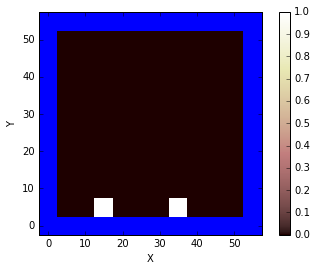

In [14]:
mg2.set_nodata_nodes_to_closed(z2, -9.)
from landlab import FIXED_VALUE_BOUNDARY
mg2.status_at_node[15]=FIXED_VALUE_BOUNDARY
mg2.status_at_node[19]=FIXED_VALUE_BOUNDARY
imshow_grid(mg2, mg2.status_at_node, color_for_closed='blue')

There are lots of ways we could have done this.  In a more complicated DEM we would probably want to search for the smallest z values in the second row in order to figure out which should be fixed values.  For more on setting raster boundary conditions see this tutorial: https://nbviewer.jupyter.org/github/landlab/tutorials/blob/master/boundary_conds/set_BCs_on_raster_perimeter.ipynb